In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import timeit

In [2]:
# paramètres de l'option
S0 = 247.12
r = 0.035
sigma = 0.2
T = 2
K = 269.99

In [3]:
# valeur exacte (analytique) de l'option
d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
C0_vrai = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
print("Valeur exacte de l'option call:", C0_vrai)

Valeur exacte de l'option call: 25.802604669573824


In [4]:
# une seule itération
n = 10**3
ST = S0

for _ in range(n):
    dt = T/n
    ST += r*ST*dt + sigma*ST*norm.rvs(scale=np.sqrt(dt))

# payoff
CT = max(0, ST - K)

# actualisation
C0 = CT * np.exp(-r*T)

print(f"ST = {ST}, CT = {CT}, C0 = {C0}")


ST = 188.0498553586321, CT = 0, C0 = 0.0


In [39]:

N = T * 260
NMC = 10**8

def mt_naive():
    def simulation():
        ST = S0
        for _ in range(N):
            dt = T/n
            ST += r*ST*dt + sigma*ST*norm.rvs(scale=np.sqrt(dt))
        CT = max(0, ST - K)
        return CT * np.exp(-r*T)

    simulations = np.array([simulation() for _ in range(NMC)])
    print("Moyenne des simulations:", simulations.mean())

###

def mt_efficient():
    dt = T/N

    ST = S0*np.ones(NMC)
    dWs = norm.rvs(scale=np.sqrt(dt), size=(N, NMC))

    for i in range(N):
        ST += r*ST*dt + sigma*ST*dWs[i]

    CT = np.maximum(ST - K, 0)
    C0 = np.exp(-r*T)*CT.mean()
    print("Moyenne des simulations:", C0)


In [40]:
ST = S0 * np.exp((r - 0.5*sigma**2)*T + sigma*norm.rvs(scale=np.sqrt(T), size=NMC))
CT = np.maximum(ST - K, 0)
C0 = np.exp(-r*T)*CT
C0MC = C0.mean()
print("Moyenne des simulations:", C0MC)

Moyenne des simulations: 25.80128806214186


In [41]:
# intervalle de confiance
# écart type empirique
sigmahat = np.std(C0, ddof=1)
# tolérance de l'intervalle de confiance
alpha = 0.05
# quantile de la loi normale
z = norm.ppf(1-alpha/2)
# intervalle
erreur = z*sigmahat/np.sqrt(NMC)
print(f"Intervalle de confiance à {1-alpha:.0%}: [{C0MC - erreur}, {C0MC + erreur}]")

Intervalle de confiance à 95%: [25.792099438836114, 25.810476685447608]


In [42]:
# valeur moyenne ST
STmean = ST.mean()
print("Valeur moyenne de ST:", STmean)
# valeur théorique de ST
STth = S0*np.exp(r*T)
print("Valeur théorique de ST:", STth)

Valeur moyenne de ST: 265.0358835954706
Valeur théorique de ST: 265.038221751542


76.48750534601368

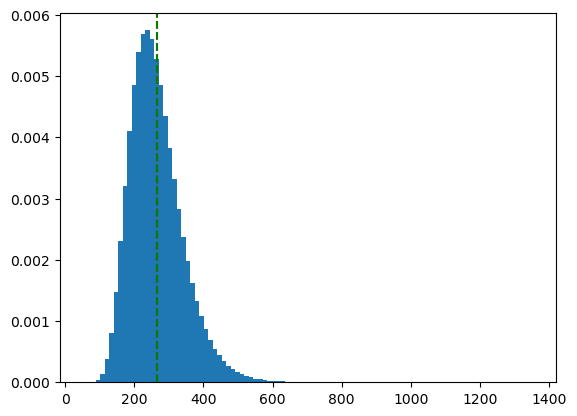

In [43]:
# histogram
plt.hist(ST, bins=100, density=True);
plt.axvline(STmean, color='r', linestyle='--', label='Moyenne empirique')
plt.axvline(STth, color='g', linestyle='--', label='Moyenne théorique')
np.std(ST)

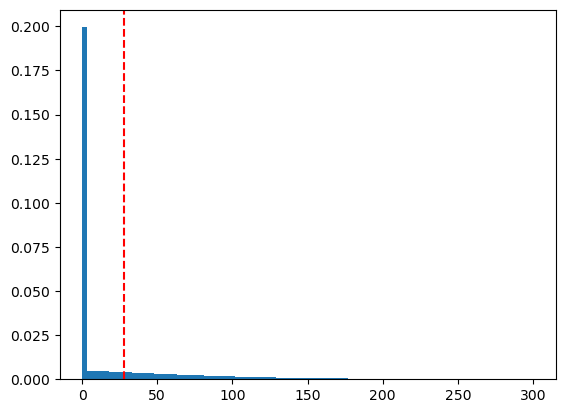

In [44]:
# distribution de CT
plt.hist(CT, bins=100, density=True, range=(0, 300));
CTvrai = C0_vrai * np.exp(r*T)
plt.axvline(CTvrai, color='r', linestyle='--', label='Valeur exacte');

ValueError: operands could not be broadcast together with shapes (100000,) (100000000,) 

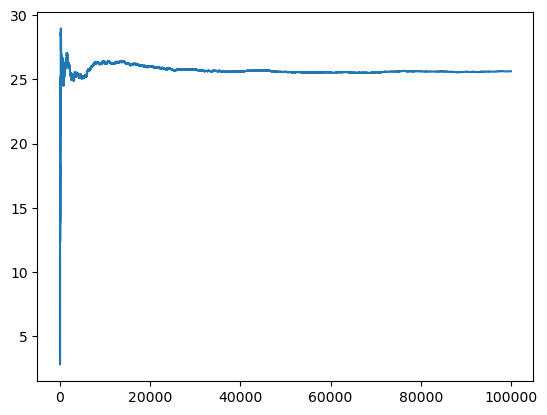

In [57]:
C0partialmean = np.cumsum(C0) / np.arange(1, NMC+1)
C0partialsquare = np.cumsum(C0**2)
sigmapartial = C0partialsquare / np.arange(1, NMC+1) - C0partialmean**2
erreur = z * sigmapartial / np.sqrt(np.arange(1, NMC+1))
plt.plot(C0_partial_mean_sample, label='Moyenne partielle');
plt.fill_between(np.arange(1, NMC + 1), C0partialmean - erreur, C0partialmean + erreur, alpha=0.2, color='r');
plt.axhline(C0_vrai, color='r', linestyle='--', label='Moyenne exacte');
plt.legend();
plt.ylim(23, 28);